<a href="https://colab.research.google.com/github/dvm14/Duke-XAI/blob/main/diya_mechanistic_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment
### Mechanistic Interpretability
### Diya Mirji


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dvm14/Duke-XAI/blob/main/diya_mechanistic_interp.ipynb)

In [17]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Duke-XAI" # Change to your repo name
git_path = 'https://github.com/dvm14/Duke-XAI.git' #Change to your path
!git clone "{git_path}"

# Change working directory to location of notebook
%cd "{repo_name}"
%ls

rm: cannot remove './sample_data': No such file or directory
Cloning into 'Duke-XAI'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 62 (delta 27), reused 13 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (62/62), 7.19 MiB | 13.81 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/Duke-XAI/Duke-XAI/Duke-XAI
diya_adversarial_patch.ipynb         machine_learning_court.ipynb
diya_assignment2.ipynb               README.md
diya_explainable_2.ipynb             Telco-Customer-Churn.csv
diya_explainable_deeplearning.ipynb  wine_quality_merged.csv
lime_exp2.png


# Example Notebook for Mechanistic Interpretability Assignment

Use this notebook as starter code for your Mechanistic Interpretability assignment. You should build your own tiny model on a tiny problem.

This could be:

* Counting 1s in binary strings (like shown here)

* Reversing short character sequences

* XOR or parity classification

* Or any other toy task you design yourself!


**Methods shown in this notebook:**
* Training a small MLP to solve a regression task (predicting the count of 1s)

* Visualizing hidden layer activations averaged by input type (number of 1s)

* Performing neuron ablation (zeroing hidden neurons) to test their functional role

* Visualizing the effect of individual neurons on the model’s output

**Additional methods you can try for your problem:**
* Inspecting activations for specific inputs (not just averaged)

* Plotting neuron selectivity curves (activation vs. input feature)

* Visualizing weight matrices to find interpretable patterns

* Perturbing inputs (e.g., flipping bits) to observe model robustness

* Comparing intermediate representations across training checkpoints

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np

### Data Generation

In [19]:
def generate_binary_data(n_samples=10000, seq_length=8):
    X = []
    y = []
    for _ in range(n_samples):
        binary_str = [random.choice([0, 1]) for _ in range(seq_length)]
        label = sum(binary_str)
        X.append(binary_str)
        y.append(label)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

seq_length = 8
n_classes = seq_length + 1
X_train, y_train = generate_binary_data(2000, seq_length)
X_val, y_val = generate_binary_data(500, seq_length)

### Build a Tiny MLP (multilayer perceptron) Model

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Updated Model for Regression
class CountingMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Output is a single scalar

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out, h  # for interpretability

# Instantiate model
model = CountingMLP(input_dim=seq_length, hidden_dim=10)
print(model)

# Convert targets to float (regression labels)
y_train_reg = y_train.float().unsqueeze(1)
y_val_reg = y_val.float().unsqueeze(1)

# Training loop with MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

losses = []
for epoch in range(100):
    model.train()
    out, _ = model(X_train)
    loss = criterion(out, y_train_reg)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print("Final training loss:", losses[-1])

# Evaluation: Mean Absolute Error + Rounded Accuracy
model.eval()
with torch.no_grad():
    preds, _ = model(X_val)
    mae = torch.abs(preds - y_val_reg).mean().item()
    rounded_preds = torch.round(preds).squeeze().long()
    accuracy = (rounded_preds == y_val).float().mean().item()

print(f"Validation MAE: {mae:.2f}")
print(f"Rounded Accuracy: {accuracy:.2f}")


CountingMLP(
  (fc1): Linear(in_features=8, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)
Final training loss: 0.09151905030012131
Validation MAE: 0.24
Rounded Accuracy: 0.91


### Print Activations of a sample input

In [21]:
with torch.no_grad():
    sample_input = torch.tensor([[1, 0, 1, 0, 1, 1, 0, 0]], dtype=torch.float32)
    logits, hidden = model(sample_input)

print(f"Sample Input: {sample_input}")
print(f"Hidden Layer Activations: {hidden}")
print(f"Output Logits: {logits}")
rounded = round(logits.item())
print(f"Rounded Prediction: {rounded}")


Sample Input: tensor([[1., 0., 1., 0., 1., 1., 0., 0.]])
Hidden Layer Activations: tensor([[1.0964, 0.0000, 1.2380, 0.4657, 0.9513, 0.0000, 2.0972, 0.0000, 2.4104,
         0.0000]])
Output Logits: tensor([[4.1172]])
Rounded Prediction: 4


### Plot hidden activations across different numbers of 1s as input

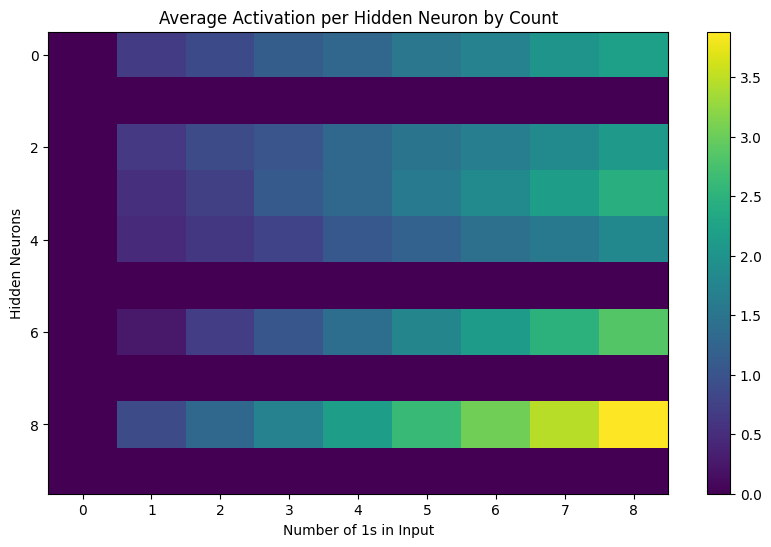

In [22]:
counts = list(range(n_classes))
avg_activations = torch.zeros((n_classes, 10))

for c in counts:
    class_inputs = X_val[y_val == c]
    if class_inputs.shape[0] > 0:
        _, h = model(class_inputs)
        avg_activations[c] = h.mean(dim=0)

plt.figure(figsize=(10, 6))
activations_np = avg_activations.T.detach().numpy()
plt.imshow(activations_np, aspect='auto', cmap='viridis')
plt.xlabel("Number of 1s in Input")
plt.ylabel("Hidden Neurons")
plt.title("Average Activation per Hidden Neuron by Count")
plt.colorbar()
plt.show()

#### **What does this plot show us?**

##### *Neuron Specialization*
Look for rows (neurons) that are brightest at specific counts.

If a neuron appears consistently dark, that could mean it is unused or suppressed.

*   My input:
* It seems that neurons 1, 5, 7, and 9 are unused or surpressed. But the other neurons have a high activation or are used most when there are 8 1s in the input, especially for neuron 8.


##### *Monotonic Trends*
If neurons show a gradual increase in activation with count — they may be learning a linear or thresholded count pattern.

That’s a great example of linearly increasing features often discussed in mechanistic interpretability (e.g. linear probe-ability).

*   My input:
* It seems that neurons 0, 2, 3, 4, 6, and 8 all gradually increase in activation as the number of 1s increase as well.

##### *Redundant or Silent Units*
Some neurons may appear flatlined which possibly means they are unused due to redundancy. *What happens if you remove the neuron entirely?

*   My input:
* It seems that neurons 1, 5, 7, and 9 are flatlined so they may be redundant. Below, I zeroed out these neurons, and there was a very small training loss and the accuracy was rounded to 1.

##### *Activation Superposition*
Some neurons activate across a range of counts, possibly blending multiple input features — this ties into superposition theory (see: Toy Models of Superposition)

_____________________

In [23]:
with torch.no_grad():
    model.fc1.weight[0, :] = 0
    model.fc1.bias[0] = 0
    model.fc2.weight[:, 0] = 0

    model.fc1.weight[4, :] = 0
    model.fc1.bias[4] = 0
    model.fc2.weight[:, 4] = 0

    model.fc1.weight[7, :] = 0
    model.fc1.bias[7] = 0
    model.fc2.weight[:, 7] = 0

    model.fc1.weight[8, :] = 0
    model.fc1.bias[8] = 0
    model.fc2.weight[:, 8] = 0

# Training loop with MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

losses = []
for epoch in range(100):
    model.train()
    out, _ = model(X_train)
    loss = criterion(out, y_train_reg)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print("Final training loss:", losses[-1])

# Evaluation: Mean Absolute Error + Rounded Accuracy
model.eval()
with torch.no_grad():
    preds, _ = model(X_val)
    mae = torch.abs(preds - y_val_reg).mean().item()
    rounded_preds = torch.round(preds).squeeze().long()
    accuracy = (rounded_preds == y_val).float().mean().item()

print(f"Validation MAE: {mae:.2f}")
print(f"Rounded Accuracy: {accuracy:.2f}")

Final training loss: 0.03506413474678993
Validation MAE: 0.15
Rounded Accuracy: 1.00


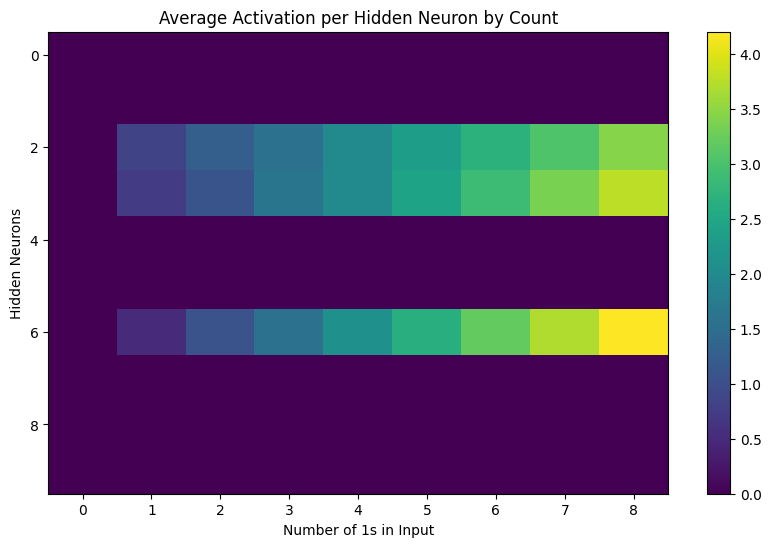

In [24]:
counts = list(range(n_classes))
avg_activations = torch.zeros((n_classes, 10))

for c in counts:
    class_inputs = X_val[y_val == c]
    if class_inputs.shape[0] > 0:
        _, h = model(class_inputs)
        avg_activations[c] = h.mean(dim=0)

plt.figure(figsize=(10, 6))
activations_np = avg_activations.T.detach().numpy()
plt.imshow(activations_np, aspect='auto', cmap='viridis')
plt.xlabel("Number of 1s in Input")
plt.ylabel("Hidden Neurons")
plt.title("Average Activation per Hidden Neuron by Count")
plt.colorbar()
plt.show()

### Neuron Ablation (single neuron)

In [25]:
#Set original model

# Instantiate model
model = CountingMLP(input_dim=seq_length, hidden_dim=10)
print(model)

# Convert targets to float (regression labels)
y_train_reg = y_train.float().unsqueeze(1)
y_val_reg = y_val.float().unsqueeze(1)

# Training loop with MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

losses = []
for epoch in range(100):
    model.train()
    out, _ = model(X_train)
    loss = criterion(out, y_train_reg)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print("Final training loss:", losses[-1])

# Evaluation: Mean Absolute Error + Rounded Accuracy
model.eval()
with torch.no_grad():
    preds, _ = model(X_val)
    mae = torch.abs(preds - y_val_reg).mean().item()
    rounded_preds = torch.round(preds).squeeze().long()
    accuracy = (rounded_preds == y_val).float().mean().item()

print(f"Validation MAE: {mae:.2f}")
print(f"Rounded Accuracy: {accuracy:.2f}")

CountingMLP(
  (fc1): Linear(in_features=8, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)
Final training loss: 0.08326186239719391
Validation MAE: 0.23
Rounded Accuracy: 0.93


In [26]:
# Sample input to test
test_input = torch.tensor([[1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.float32)  # Example: 4 ones
true_count = int(test_input.sum().item())

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    baseline_pred = baseline_output.item()

for i in range(10):
  # Zero out one neuron in the hidden layer (e.g., neuron 3)
  neuron_to_zero = i

  # Manually run forward pass with neuron ablated
  with torch.no_grad():
      h = F.relu(model.fc1(test_input))
      h[:, neuron_to_zero] = 0  # zeroing neuron
      modified_output = model.fc2(h)
      modified_pred = modified_output.item()

  print(f"\nNeuron {i}")
  print(f"True count: {true_count}")
  print(f"Prediction (normal): {baseline_pred:.2f}")
  print(f"Prediction (with neuron {neuron_to_zero} zeroed): {modified_pred:.2f}")

  delta = modified_pred - baseline_pred
  if delta > 0:
      print(f"➕ Prediction increased by {delta:.2f}")
  elif delta < 0:
      print(f"➖ Prediction decreased by {abs(delta):.2f}")
  else:
      print("⚖️ No change in prediction")



Neuron 0
True count: 4
Prediction (normal): 4.18
Prediction (with neuron 0 zeroed): 4.18
⚖️ No change in prediction

Neuron 1
True count: 4
Prediction (normal): 4.18
Prediction (with neuron 1 zeroed): 3.78
➖ Prediction decreased by 0.40

Neuron 2
True count: 4
Prediction (normal): 4.18
Prediction (with neuron 2 zeroed): 3.44
➖ Prediction decreased by 0.73

Neuron 3
True count: 4
Prediction (normal): 4.18
Prediction (with neuron 3 zeroed): 3.71
➖ Prediction decreased by 0.46

Neuron 4
True count: 4
Prediction (normal): 4.18
Prediction (with neuron 4 zeroed): 4.18
⚖️ No change in prediction

Neuron 5
True count: 4
Prediction (normal): 4.18
Prediction (with neuron 5 zeroed): 3.41
➖ Prediction decreased by 0.77

Neuron 6
True count: 4
Prediction (normal): 4.18
Prediction (with neuron 6 zeroed): 4.18
⚖️ No change in prediction

Neuron 7
True count: 4
Prediction (normal): 4.18
Prediction (with neuron 7 zeroed): 4.18
⚖️ No change in prediction

Neuron 8
True count: 4
Prediction (normal): 4.1

#### **What does the ablation tell us?**

If the prediction changes significantly after zeroing out a neuron, that neuron likely plays an important functional role in the model’s decision!

* My input:
* Neuron 1, 2, 3, 5, 8, 9 all decrease the prediction after zeroing out that neuron. So the neuron with the highest impact is neuron 9.

### Neuron Ablation (sweep of neurons)

🧾 True count: 4, Baseline prediction: 4.18


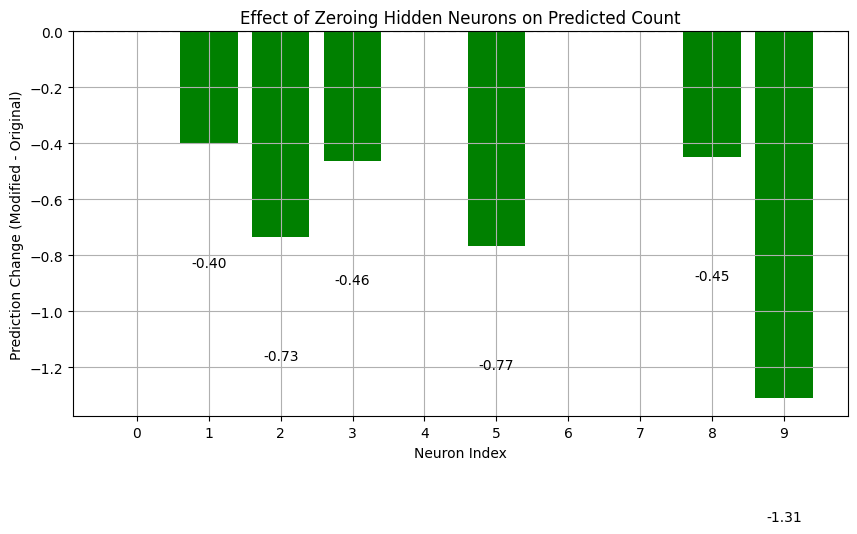

Neuron 1 → Prediction decreased by 0.40
Neuron 2 → Prediction decreased by 0.73
Neuron 3 → Prediction decreased by 0.46
Neuron 5 → Prediction decreased by 0.77
Neuron 8 → Prediction decreased by 0.45
Neuron 9 → Prediction decreased by 1.31


In [27]:
# Sample input to test
test_input = torch.tensor([[1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.float32)
true_count = int(test_input.sum().item())

# Baseline prediction
model.eval()
with torch.no_grad():
    baseline_output, _ = model(test_input)
    baseline_pred = baseline_output.item()

print(f"🧾 True count: {true_count}, Baseline prediction: {baseline_pred:.2f}")

# Sweep: get signed change in scalar prediction
neuron_indices = list(range(model.fc1.out_features))
signed_deltas = []

for i in neuron_indices:
    with torch.no_grad():
        h = F.relu(model.fc1(test_input))
        h[:, i] = 0  # zero out neuron i
        mod_output = model.fc2(h)
        mod_pred = mod_output.item()
        signed_deltas.append(mod_pred - baseline_pred)

# Plotting signed prediction change per neuron
plt.figure(figsize=(10, 5))
colors = ['green' if d < 0 else 'red' if d > 0 else 'gray' for d in signed_deltas]

plt.bar(neuron_indices, signed_deltas, color=colors)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(neuron_indices)
plt.xlabel("Neuron Index")
plt.ylabel("Prediction Change (Modified - Original)")
plt.title("Effect of Zeroing Hidden Neurons on Predicted Count")
plt.grid(True)

# Annotatation
for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        plt.text(i, d + (0.2 if d > 0 else -0.4), f"{d:+.2f}",
                 ha='center', va='bottom' if d > 0 else 'top')

plt.show()

# Summary
for i, d in enumerate(signed_deltas):
    if abs(d) > 1e-3:
        direction = "increased" if d > 0 else "decreased"
        print(f"Neuron {i} → Prediction {direction} by {abs(d):.2f}")


#### **What does the sweep of neuron ablations tell us?**

Which neurons had the most impact on predictions?
* My input:
* The top 3 neurons with the most impact on predictions were Neuron 9, 5, and 2 because they had the largest decrease in predictions.

Are there redundant neurons (zeroing them causes no change)?
* My input:
* The redundant neurons with no change in predictions were neurons 0, 4, 6, and 7 because their prediction change was 0 even after zeroing those neurons.

Sample: [1, 0, 0, 0, 0, 0, 0, 0]
🧾 True count: 1, Baseline prediction: 1.55


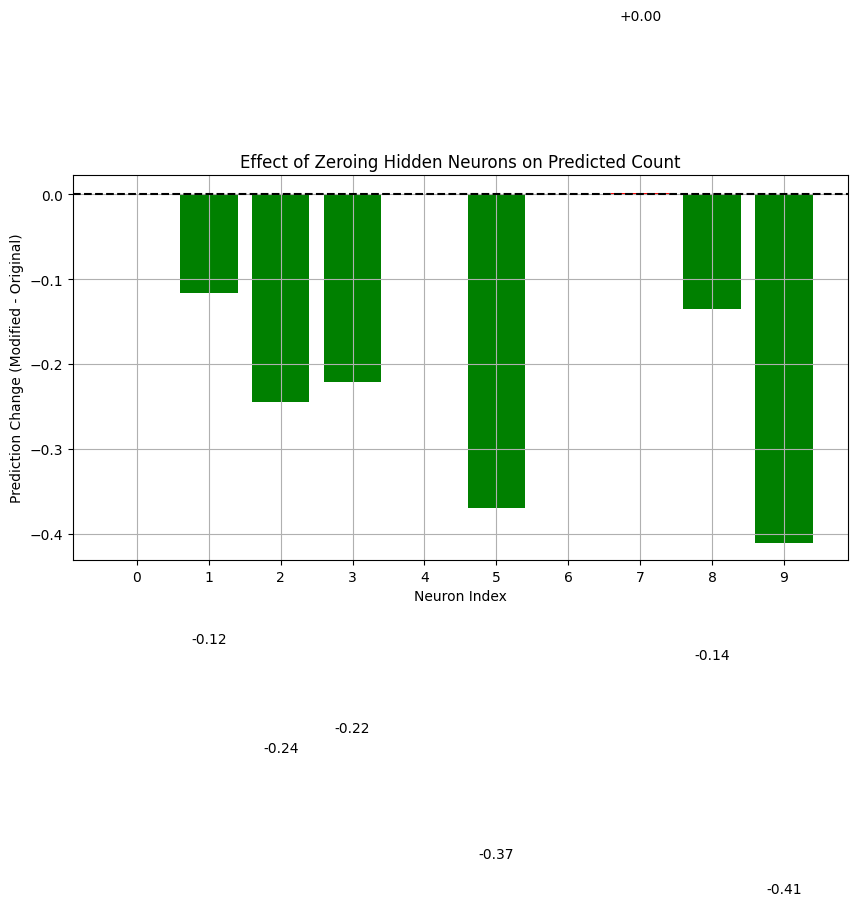

Neuron 1 → Prediction decreased by 0.12
Neuron 2 → Prediction decreased by 0.24
Neuron 3 → Prediction decreased by 0.22
Neuron 5 → Prediction decreased by 0.37
Neuron 7 → Prediction increased by 0.00
Neuron 8 → Prediction decreased by 0.14
Neuron 9 → Prediction decreased by 0.41



Sample: [0, 1, 0, 0, 0, 0, 0, 0]
🧾 True count: 1, Baseline prediction: 1.56


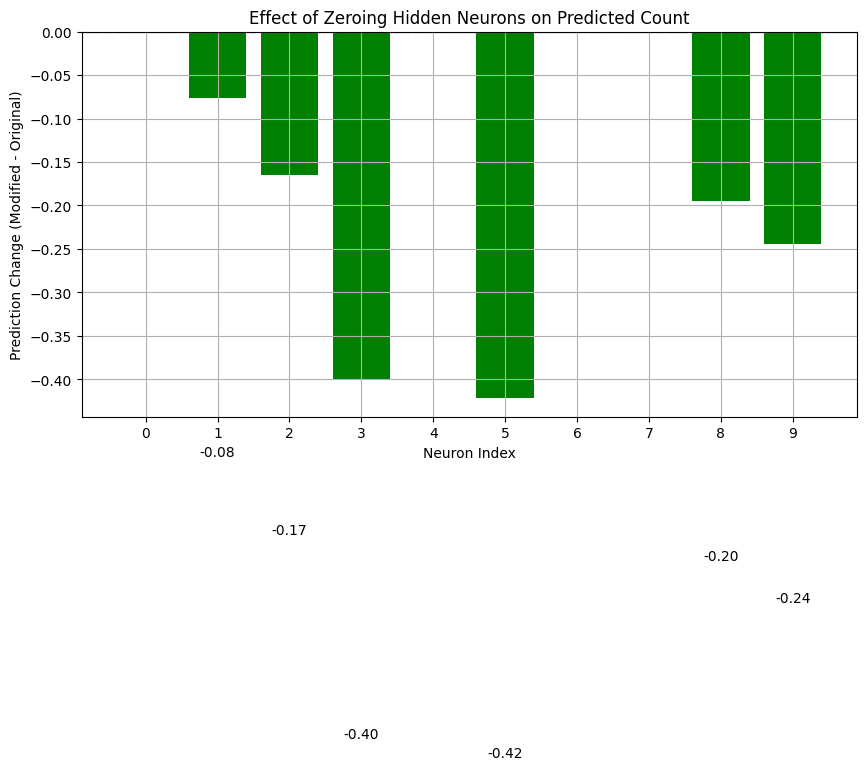

Neuron 1 → Prediction decreased by 0.08
Neuron 2 → Prediction decreased by 0.17
Neuron 3 → Prediction decreased by 0.40
Neuron 5 → Prediction decreased by 0.42
Neuron 8 → Prediction decreased by 0.20
Neuron 9 → Prediction decreased by 0.24



Sample: [0, 0, 1, 0, 0, 0, 0, 0]
🧾 True count: 1, Baseline prediction: 1.74


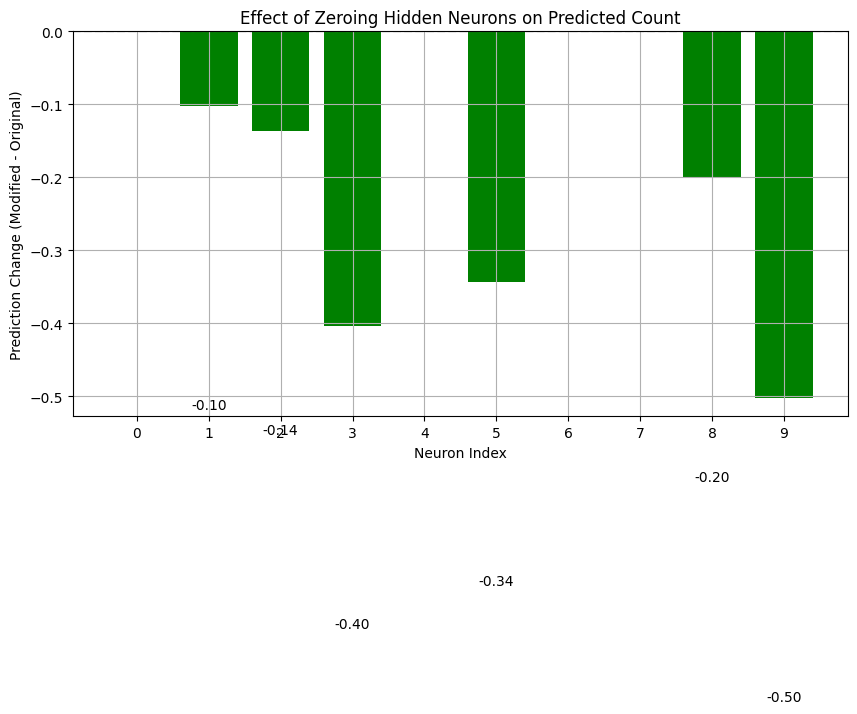

Neuron 1 → Prediction decreased by 0.10
Neuron 2 → Prediction decreased by 0.14
Neuron 3 → Prediction decreased by 0.40
Neuron 5 → Prediction decreased by 0.34
Neuron 8 → Prediction decreased by 0.20
Neuron 9 → Prediction decreased by 0.50



Sample: [0, 0, 0, 1, 0, 0, 0, 0]
🧾 True count: 1, Baseline prediction: 1.67


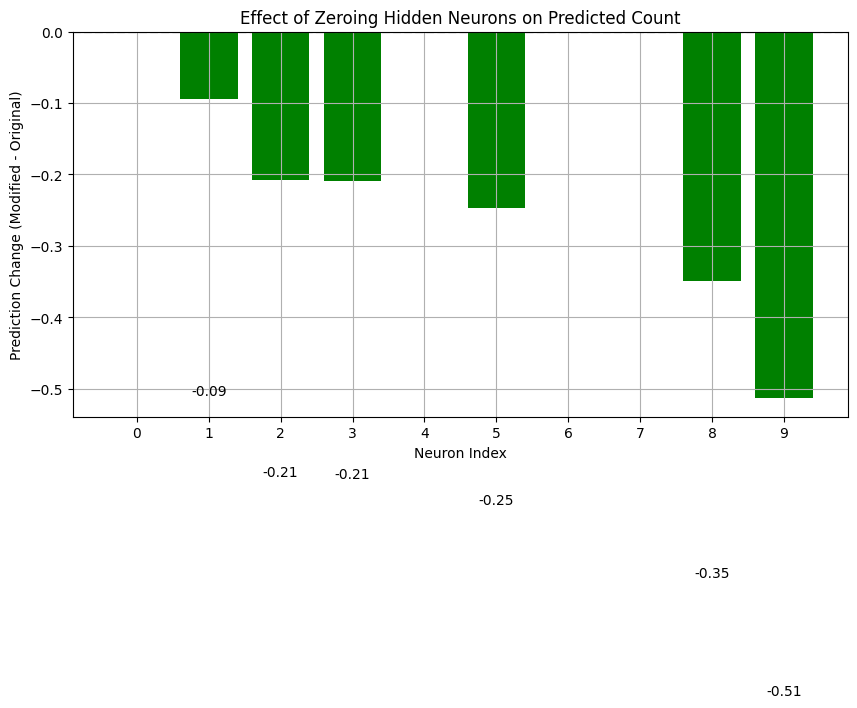

Neuron 1 → Prediction decreased by 0.09
Neuron 2 → Prediction decreased by 0.21
Neuron 3 → Prediction decreased by 0.21
Neuron 5 → Prediction decreased by 0.25
Neuron 8 → Prediction decreased by 0.35
Neuron 9 → Prediction decreased by 0.51



Sample: [0, 0, 0, 0, 1, 0, 0, 0]
🧾 True count: 1, Baseline prediction: 1.56


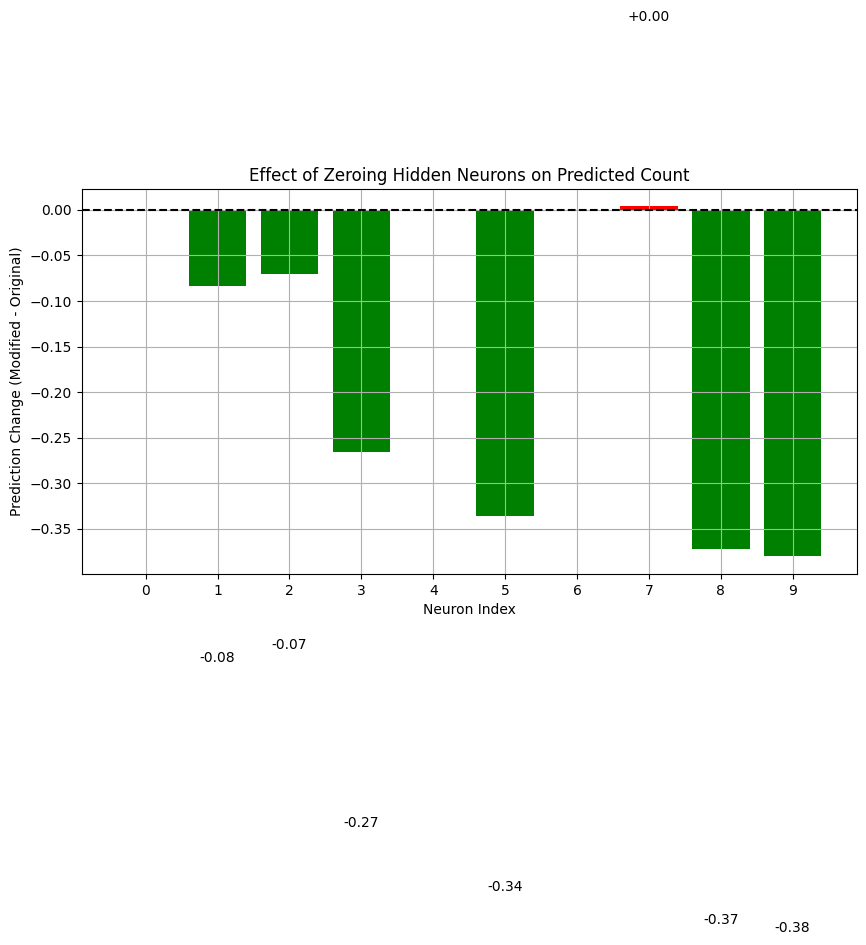

Neuron 1 → Prediction decreased by 0.08
Neuron 2 → Prediction decreased by 0.07
Neuron 3 → Prediction decreased by 0.27
Neuron 5 → Prediction decreased by 0.34
Neuron 7 → Prediction increased by 0.00
Neuron 8 → Prediction decreased by 0.37
Neuron 9 → Prediction decreased by 0.38



Sample: [0, 0, 0, 0, 0, 1, 0, 0]
🧾 True count: 1, Baseline prediction: 1.58


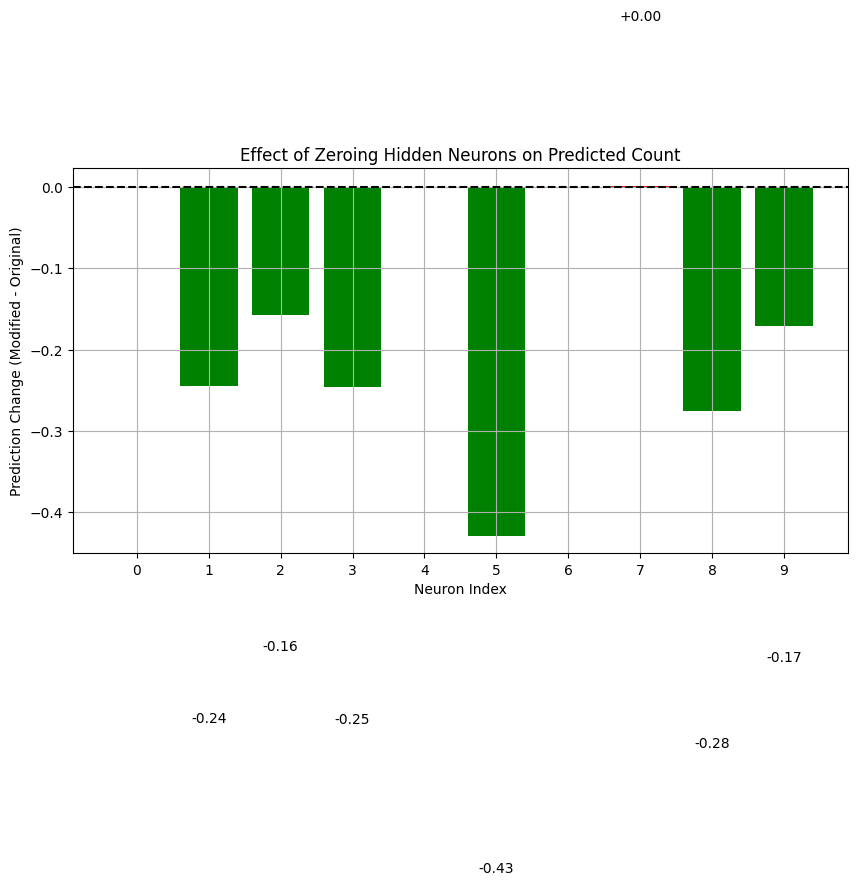

Neuron 1 → Prediction decreased by 0.24
Neuron 2 → Prediction decreased by 0.16
Neuron 3 → Prediction decreased by 0.25
Neuron 5 → Prediction decreased by 0.43
Neuron 7 → Prediction increased by 0.00
Neuron 8 → Prediction decreased by 0.28
Neuron 9 → Prediction decreased by 0.17



Sample: [0, 0, 0, 0, 0, 0, 1, 0]
🧾 True count: 1, Baseline prediction: 1.48


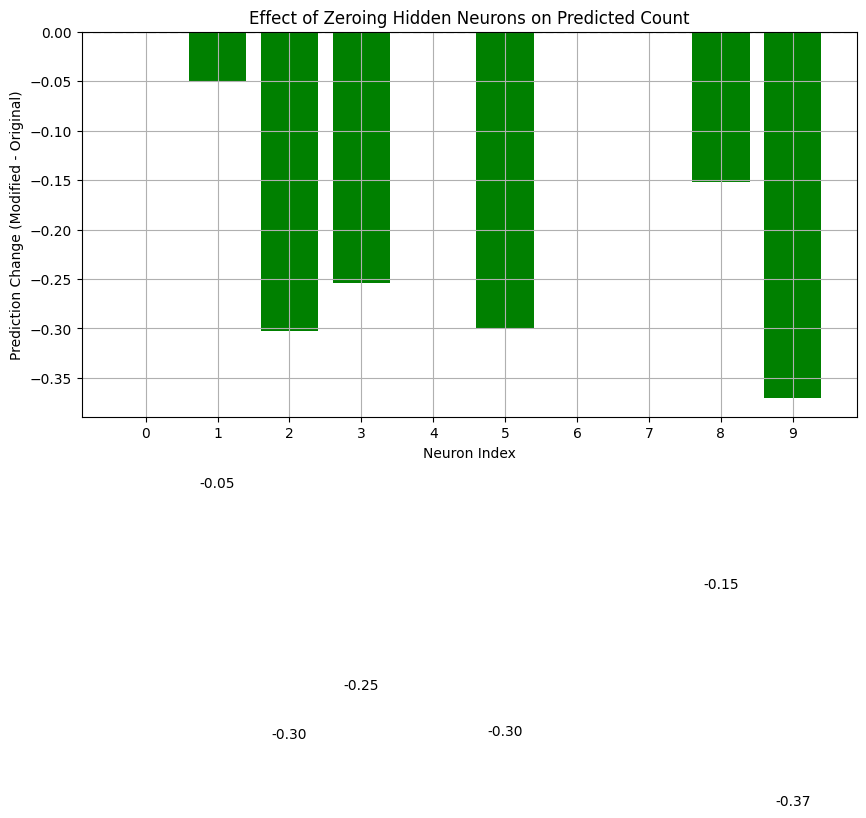

Neuron 1 → Prediction decreased by 0.05
Neuron 2 → Prediction decreased by 0.30
Neuron 3 → Prediction decreased by 0.25
Neuron 5 → Prediction decreased by 0.30
Neuron 8 → Prediction decreased by 0.15
Neuron 9 → Prediction decreased by 0.37



Sample: [0, 0, 0, 0, 0, 0, 0, 1]
🧾 True count: 1, Baseline prediction: 1.48


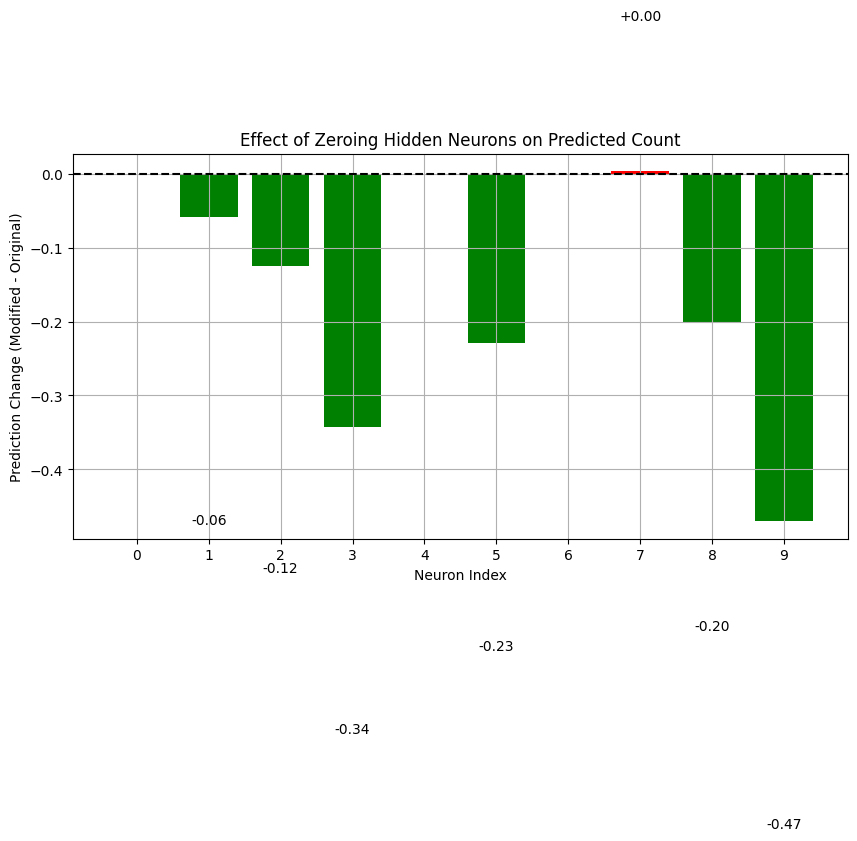

Neuron 1 → Prediction decreased by 0.06
Neuron 2 → Prediction decreased by 0.12
Neuron 3 → Prediction decreased by 0.34
Neuron 5 → Prediction decreased by 0.23
Neuron 7 → Prediction increased by 0.00
Neuron 8 → Prediction decreased by 0.20
Neuron 9 → Prediction decreased by 0.47





In [28]:
for i in range(8):
  samples = [0, 0, 0, 0, 0, 0, 0, 0]
  samples[i] = 1
  print(f"Sample: {samples}")

  # Sample input to test
  test_input = torch.tensor([samples], dtype=torch.float32)
  true_count = int(test_input.sum().item())

  # Baseline prediction
  model.eval()
  with torch.no_grad():
      baseline_output, _ = model(test_input)
      baseline_pred = baseline_output.item()

  print(f"🧾 True count: {true_count}, Baseline prediction: {baseline_pred:.2f}")

  # Sweep: get signed change in scalar prediction
  neuron_indices = list(range(model.fc1.out_features))
  signed_deltas = []

  for i in neuron_indices:
      with torch.no_grad():
          h = F.relu(model.fc1(test_input))
          h[:, i] = 0  # zero out neuron i
          mod_output = model.fc2(h)
          mod_pred = mod_output.item()
          signed_deltas.append(mod_pred - baseline_pred)

  # Plotting signed prediction change per neuron
  plt.figure(figsize=(10, 5))
  colors = ['green' if d < 0 else 'red' if d > 0 else 'gray' for d in signed_deltas]

  plt.bar(neuron_indices, signed_deltas, color=colors)
  plt.axhline(0, color='black', linestyle='--')
  plt.xticks(neuron_indices)
  plt.xlabel("Neuron Index")
  plt.ylabel("Prediction Change (Modified - Original)")
  plt.title("Effect of Zeroing Hidden Neurons on Predicted Count")
  plt.grid(True)

  # Annotatation
  for i, d in enumerate(signed_deltas):
      if abs(d) > 1e-3:
          plt.text(i, d + (0.2 if d > 0 else -0.4), f"{d:+.2f}",
                  ha='center', va='bottom' if d > 0 else 'top')

  plt.show()

  # Summary
  for i, d in enumerate(signed_deltas):
      if abs(d) > 1e-3:
          direction = "increased" if d > 0 else "decreased"
          print(f"Neuron {i} → Prediction {direction} by {abs(d):.2f}")
  print("\n\n")

Above, I did an ablation neuron sweep for each test sample. The sample changes by moving the 1 in the different positions of the binary number. It seems that there is not much change and the prediction change is about the same for each of the neurons when zeroed.

Sample: [1, 0, 0, 0, 0, 0, 0, 0]
🧾 True count: 1, Baseline prediction: 1.55


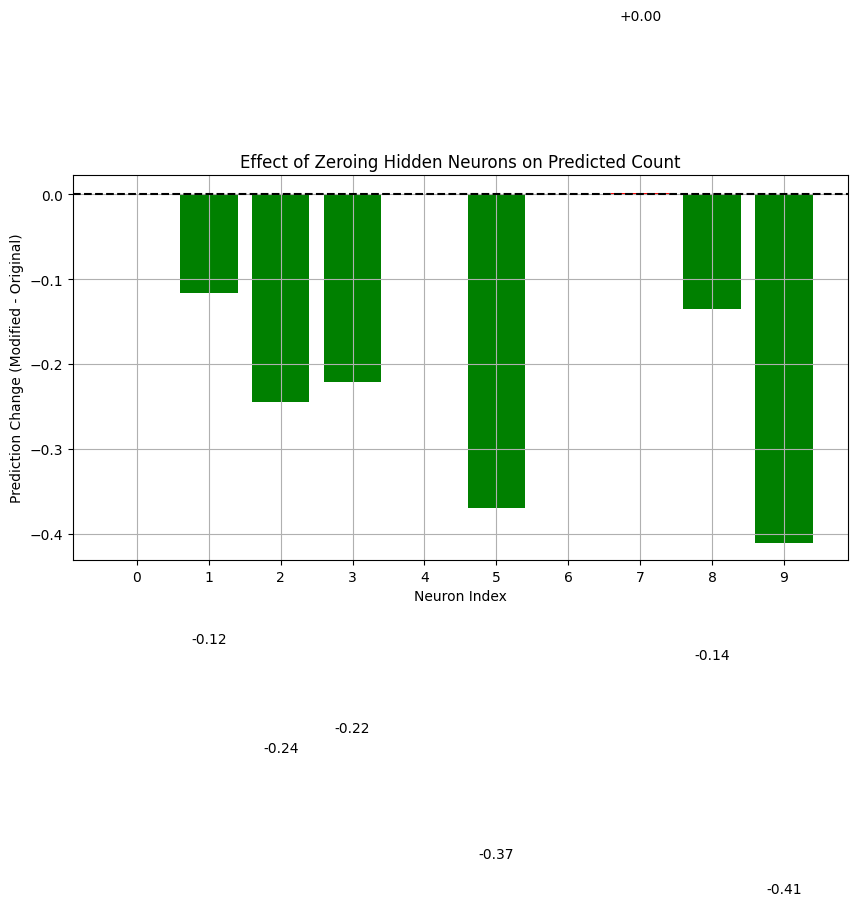

Neuron 1 → Prediction decreased by 0.12
Neuron 2 → Prediction decreased by 0.24
Neuron 3 → Prediction decreased by 0.22
Neuron 5 → Prediction decreased by 0.37
Neuron 7 → Prediction increased by 0.00
Neuron 8 → Prediction decreased by 0.14
Neuron 9 → Prediction decreased by 0.41



Sample: [1, 1, 0, 0, 0, 0, 0, 0]
🧾 True count: 2, Baseline prediction: 2.35


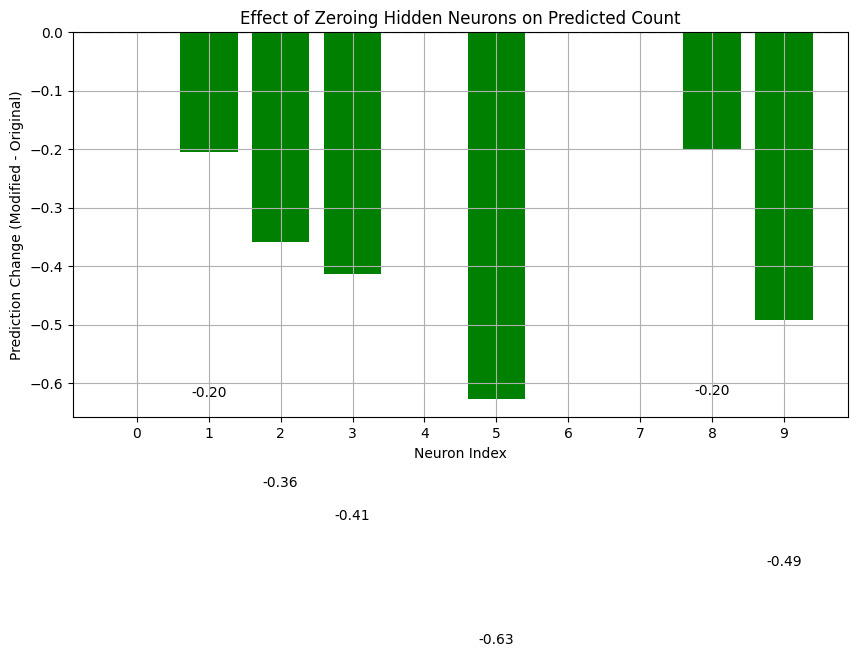

Neuron 1 → Prediction decreased by 0.20
Neuron 2 → Prediction decreased by 0.36
Neuron 3 → Prediction decreased by 0.41
Neuron 5 → Prediction decreased by 0.63
Neuron 8 → Prediction decreased by 0.20
Neuron 9 → Prediction decreased by 0.49



Sample: [1, 1, 1, 0, 0, 0, 0, 0]
🧾 True count: 3, Baseline prediction: 3.34


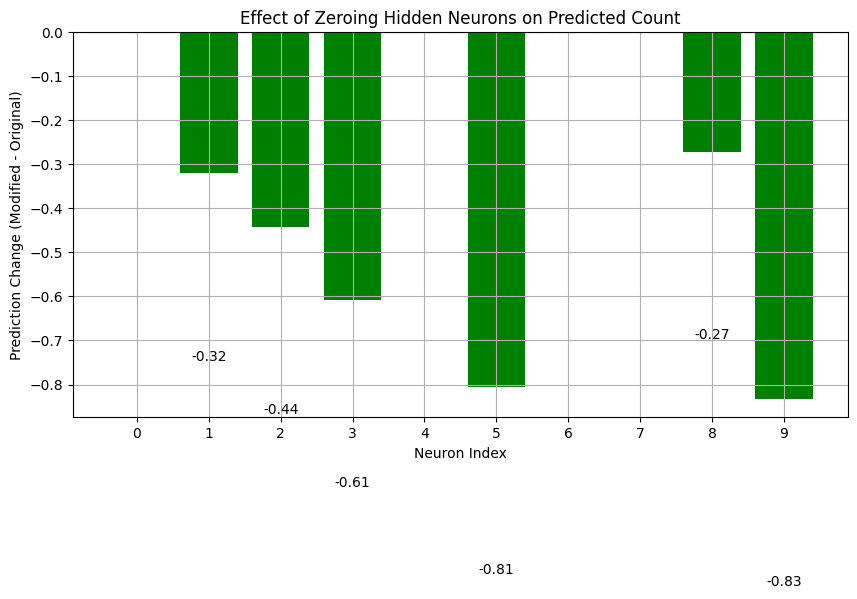

Neuron 1 → Prediction decreased by 0.32
Neuron 2 → Prediction decreased by 0.44
Neuron 3 → Prediction decreased by 0.61
Neuron 5 → Prediction decreased by 0.81
Neuron 8 → Prediction decreased by 0.27
Neuron 9 → Prediction decreased by 0.83



Sample: [1, 1, 1, 1, 0, 0, 0, 0]
🧾 True count: 4, Baseline prediction: 4.25


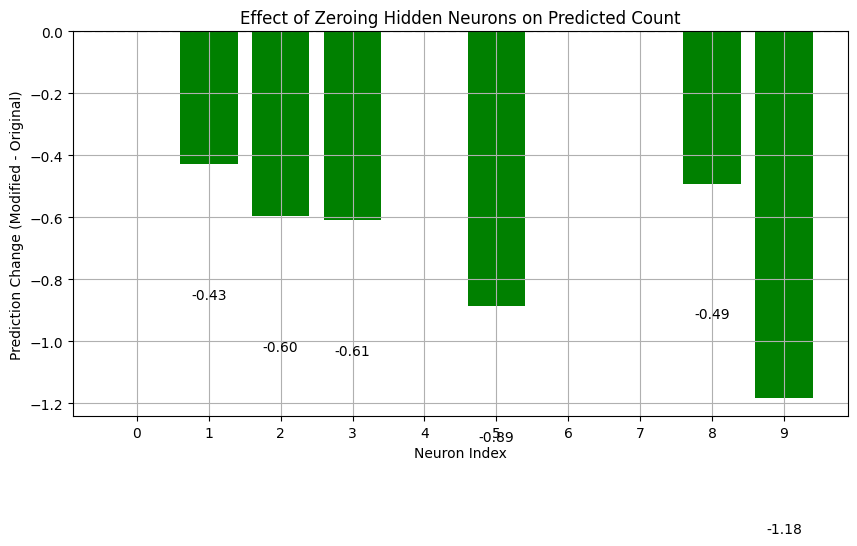

Neuron 1 → Prediction decreased by 0.43
Neuron 2 → Prediction decreased by 0.60
Neuron 3 → Prediction decreased by 0.61
Neuron 5 → Prediction decreased by 0.89
Neuron 8 → Prediction decreased by 0.49
Neuron 9 → Prediction decreased by 1.18



Sample: [1, 1, 1, 1, 1, 0, 0, 0]
🧾 True count: 5, Baseline prediction: 5.05


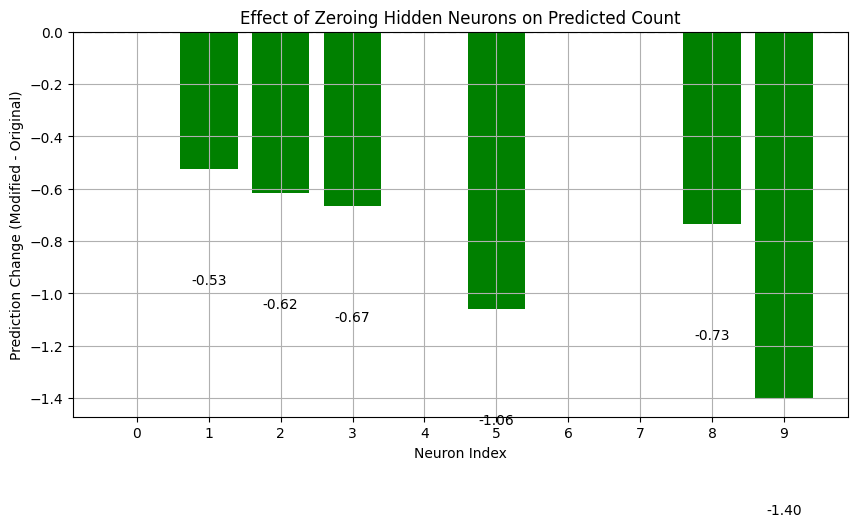

Neuron 1 → Prediction decreased by 0.53
Neuron 2 → Prediction decreased by 0.62
Neuron 3 → Prediction decreased by 0.67
Neuron 5 → Prediction decreased by 1.06
Neuron 8 → Prediction decreased by 0.73
Neuron 9 → Prediction decreased by 1.40



Sample: [1, 1, 1, 1, 1, 1, 0, 0]
🧾 True count: 6, Baseline prediction: 5.87


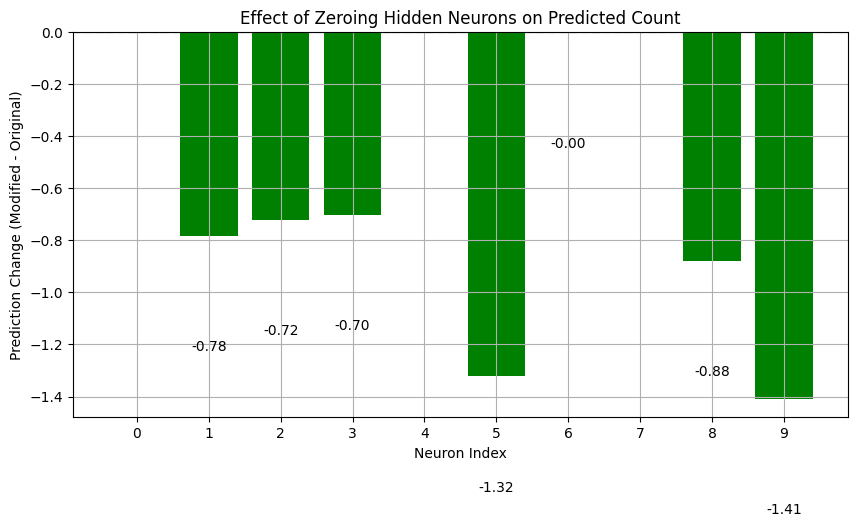

Neuron 1 → Prediction decreased by 0.78
Neuron 2 → Prediction decreased by 0.72
Neuron 3 → Prediction decreased by 0.70
Neuron 5 → Prediction decreased by 1.32
Neuron 6 → Prediction decreased by 0.00
Neuron 8 → Prediction decreased by 0.88
Neuron 9 → Prediction decreased by 1.41



Sample: [1, 1, 1, 1, 1, 1, 1, 0]
🧾 True count: 7, Baseline prediction: 6.60


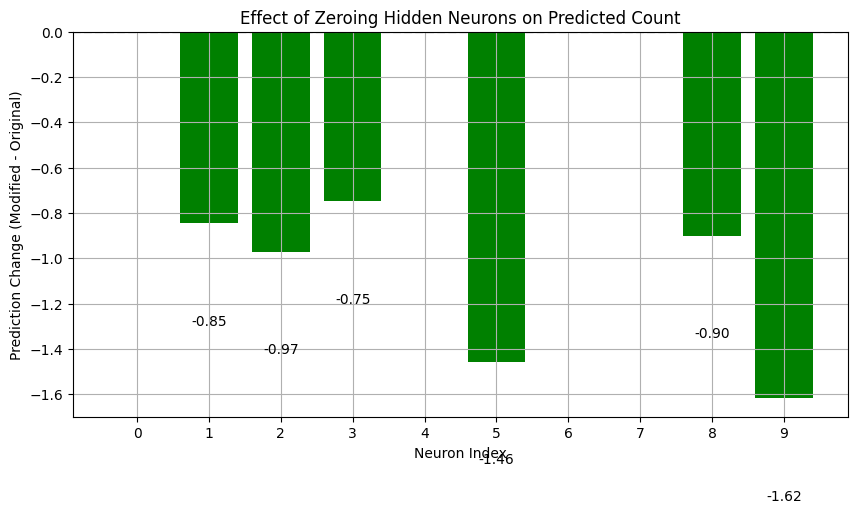

Neuron 1 → Prediction decreased by 0.85
Neuron 2 → Prediction decreased by 0.97
Neuron 3 → Prediction decreased by 0.75
Neuron 5 → Prediction decreased by 1.46
Neuron 8 → Prediction decreased by 0.90
Neuron 9 → Prediction decreased by 1.62



Sample: [1, 1, 1, 1, 1, 1, 1, 1]
🧾 True count: 8, Baseline prediction: 7.32


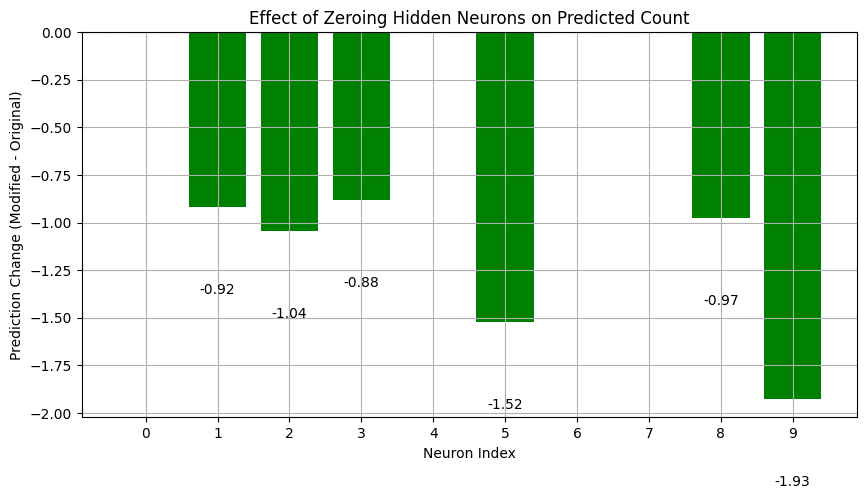

Neuron 1 → Prediction decreased by 0.92
Neuron 2 → Prediction decreased by 1.04
Neuron 3 → Prediction decreased by 0.88
Neuron 5 → Prediction decreased by 1.52
Neuron 8 → Prediction decreased by 0.97
Neuron 9 → Prediction decreased by 1.93





In [29]:
samples = [0, 0, 0, 0, 0, 0, 0, 0]
for i in range(8):
  samples[i] = 1
  print(f"Sample: {samples}")

  # Sample input to test
  test_input = torch.tensor([samples], dtype=torch.float32)
  true_count = int(test_input.sum().item())

  # Baseline prediction
  model.eval()
  with torch.no_grad():
      baseline_output, _ = model(test_input)
      baseline_pred = baseline_output.item()

  print(f"🧾 True count: {true_count}, Baseline prediction: {baseline_pred:.2f}")

  # Sweep: get signed change in scalar prediction
  neuron_indices = list(range(model.fc1.out_features))
  signed_deltas = []

  for i in neuron_indices:
      with torch.no_grad():
          h = F.relu(model.fc1(test_input))
          h[:, i] = 0  # zero out neuron i
          mod_output = model.fc2(h)
          mod_pred = mod_output.item()
          signed_deltas.append(mod_pred - baseline_pred)

  # Plotting signed prediction change per neuron
  plt.figure(figsize=(10, 5))
  colors = ['green' if d < 0 else 'red' if d > 0 else 'gray' for d in signed_deltas]

  plt.bar(neuron_indices, signed_deltas, color=colors)
  plt.axhline(0, color='black', linestyle='--')
  plt.xticks(neuron_indices)
  plt.xlabel("Neuron Index")
  plt.ylabel("Prediction Change (Modified - Original)")
  plt.title("Effect of Zeroing Hidden Neurons on Predicted Count")
  plt.grid(True)

  # Annotatation
  for i, d in enumerate(signed_deltas):
      if abs(d) > 1e-3:
          plt.text(i, d + (0.2 if d > 0 else -0.4), f"{d:+.2f}",
                  ha='center', va='bottom' if d > 0 else 'top')

  plt.show()

  # Summary
  for i, d in enumerate(signed_deltas):
      if abs(d) > 1e-3:
          direction = "increased" if d > 0 else "decreased"
          print(f"Neuron {i} → Prediction {direction} by {abs(d):.2f}")
  print("\n\n")

Above, I did an another ablation neuron sweep for each test sample. The sample changes by adding a 1 to each position of the binary number. It seems that there is not much change and the prediction change is about the same for each of the neurons when zeroed.

Sample: [0, 1, 1, 1, 1, 1, 1, 1]
🧾 True count: 7, Baseline prediction: 6.53


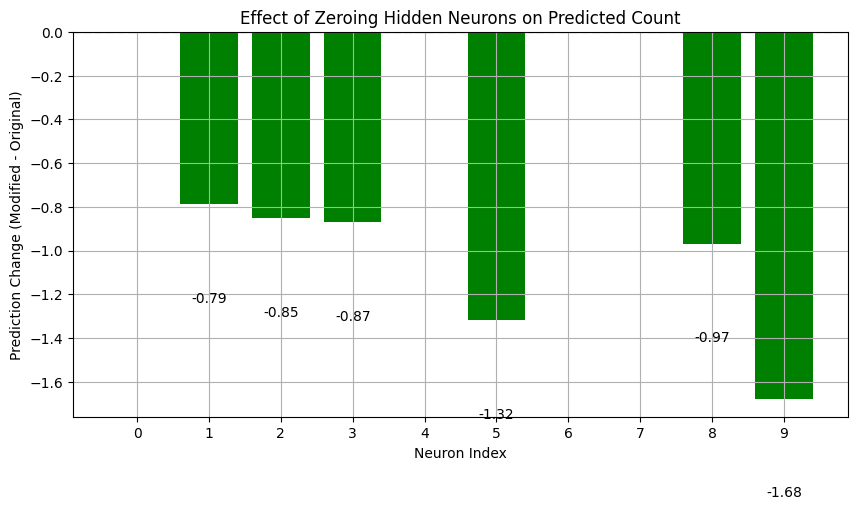

Neuron 1 → Prediction decreased by 0.79
Neuron 2 → Prediction decreased by 0.85
Neuron 3 → Prediction decreased by 0.87
Neuron 5 → Prediction decreased by 1.32
Neuron 8 → Prediction decreased by 0.97
Neuron 9 → Prediction decreased by 1.68



Sample: [1, 0, 1, 1, 1, 1, 1, 1]
🧾 True count: 7, Baseline prediction: 6.52


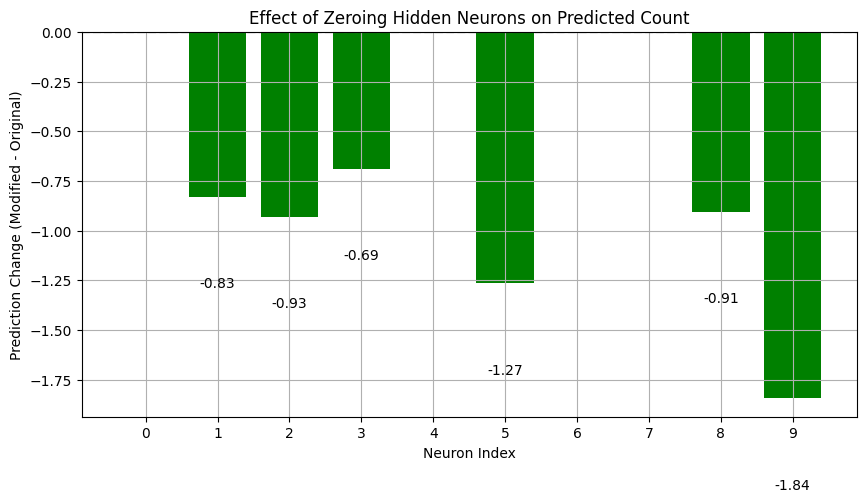

Neuron 1 → Prediction decreased by 0.83
Neuron 2 → Prediction decreased by 0.93
Neuron 3 → Prediction decreased by 0.69
Neuron 5 → Prediction decreased by 1.27
Neuron 8 → Prediction decreased by 0.91
Neuron 9 → Prediction decreased by 1.84



Sample: [1, 1, 0, 1, 1, 1, 1, 1]
🧾 True count: 7, Baseline prediction: 6.34


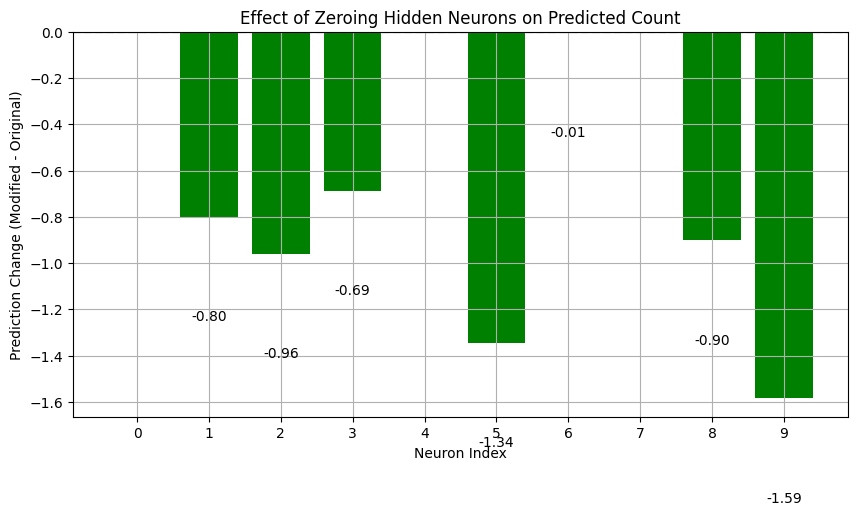

Neuron 1 → Prediction decreased by 0.80
Neuron 2 → Prediction decreased by 0.96
Neuron 3 → Prediction decreased by 0.69
Neuron 5 → Prediction decreased by 1.34
Neuron 6 → Prediction decreased by 0.01
Neuron 8 → Prediction decreased by 0.90
Neuron 9 → Prediction decreased by 1.59



Sample: [1, 1, 1, 0, 1, 1, 1, 1]
🧾 True count: 7, Baseline prediction: 6.40


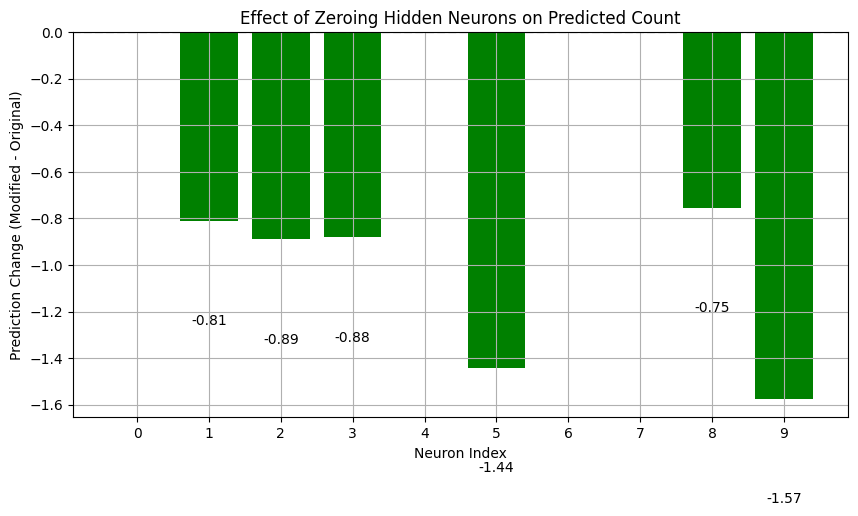

Neuron 1 → Prediction decreased by 0.81
Neuron 2 → Prediction decreased by 0.89
Neuron 3 → Prediction decreased by 0.88
Neuron 5 → Prediction decreased by 1.44
Neuron 8 → Prediction decreased by 0.75
Neuron 9 → Prediction decreased by 1.57



Sample: [1, 1, 1, 1, 0, 1, 1, 1]
🧾 True count: 7, Baseline prediction: 6.52


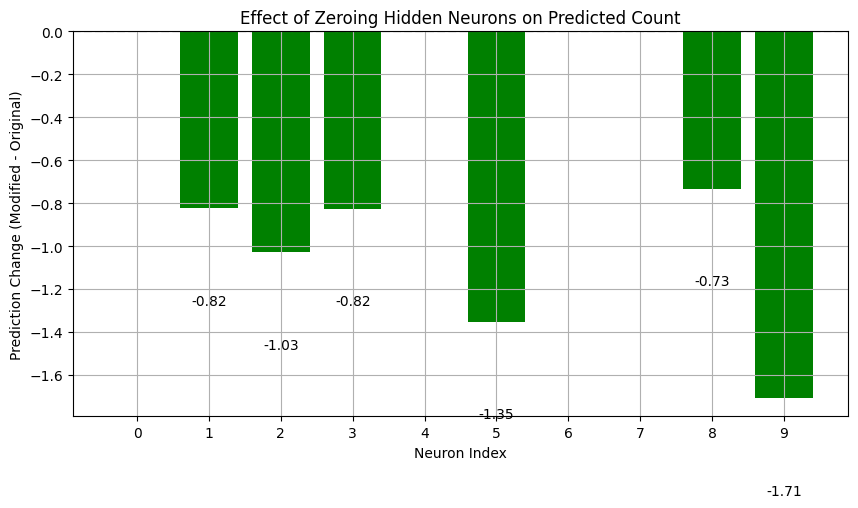

Neuron 1 → Prediction decreased by 0.82
Neuron 2 → Prediction decreased by 1.03
Neuron 3 → Prediction decreased by 0.82
Neuron 5 → Prediction decreased by 1.35
Neuron 8 → Prediction decreased by 0.73
Neuron 9 → Prediction decreased by 1.71



Sample: [1, 1, 1, 1, 1, 0, 1, 1]
🧾 True count: 7, Baseline prediction: 6.50


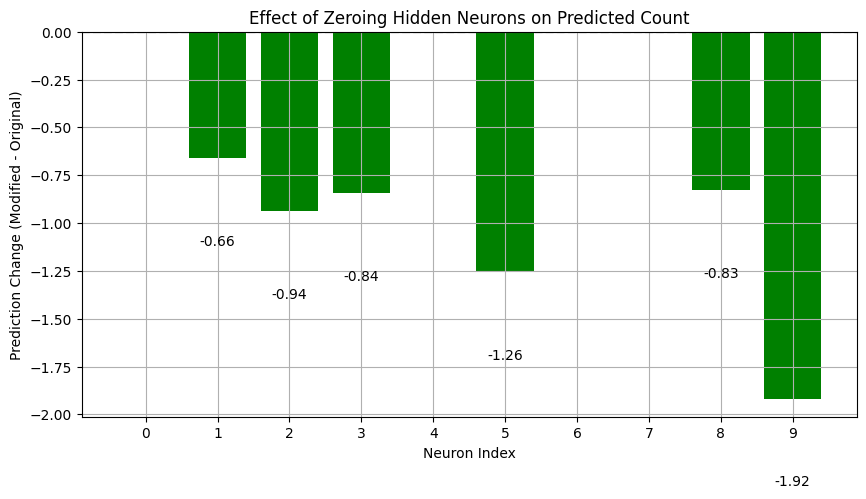

Neuron 1 → Prediction decreased by 0.66
Neuron 2 → Prediction decreased by 0.94
Neuron 3 → Prediction decreased by 0.84
Neuron 5 → Prediction decreased by 1.26
Neuron 8 → Prediction decreased by 0.83
Neuron 9 → Prediction decreased by 1.92



Sample: [1, 1, 1, 1, 1, 1, 0, 1]
🧾 True count: 7, Baseline prediction: 6.60


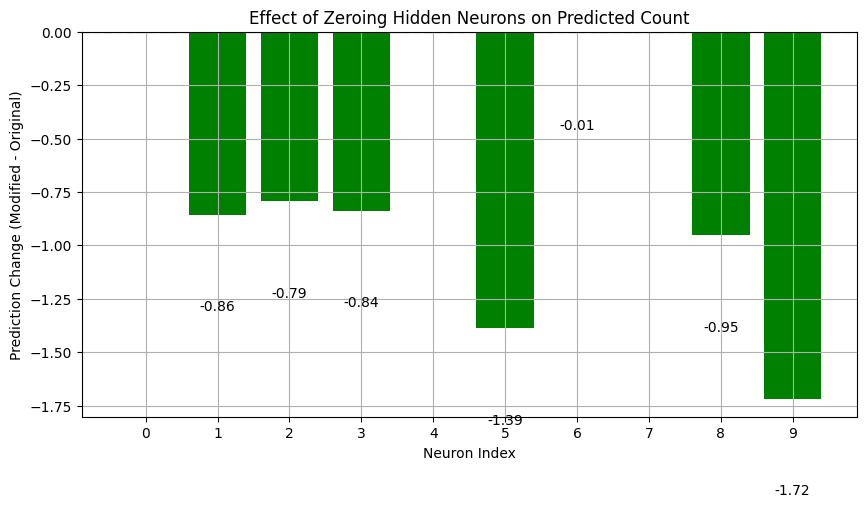

Neuron 1 → Prediction decreased by 0.86
Neuron 2 → Prediction decreased by 0.79
Neuron 3 → Prediction decreased by 0.84
Neuron 5 → Prediction decreased by 1.39
Neuron 6 → Prediction decreased by 0.01
Neuron 8 → Prediction decreased by 0.95
Neuron 9 → Prediction decreased by 1.72



Sample: [1, 1, 1, 1, 1, 1, 1, 0]
🧾 True count: 7, Baseline prediction: 6.60


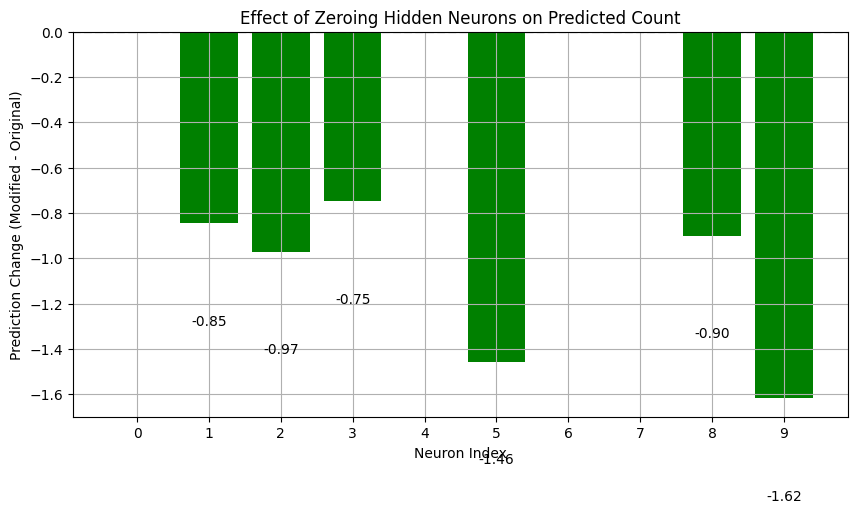

Neuron 1 → Prediction decreased by 0.85
Neuron 2 → Prediction decreased by 0.97
Neuron 3 → Prediction decreased by 0.75
Neuron 5 → Prediction decreased by 1.46
Neuron 8 → Prediction decreased by 0.90
Neuron 9 → Prediction decreased by 1.62



Neuron 0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Neuron 1: [-0.7892026901245117, -0.8288121223449707, -0.8021974563598633, -0.8106698989868164, -0.8210334777832031, -0.6601390838623047, -0.855433464050293, -0.8457112312316895]
Neuron 2: [-0.8519387245178223, -0.9307713508605957, -0.9599604606628418, -0.8890995979309082, -1.0262465476989746, -0.9393610954284668, -0.7930746078491211, -0.9713249206542969]
Neuron 3: [-0.8685398101806641, -0.6893033981323242, -0.687044620513916, -0.8803668022155762, -0.8249850273132324, -0.8443312644958496, -0.8365135192871094, -0.7480278015136719]
Neuron 4: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Neuron 5: [-1.3178033828735352, -1.2655525207519531, -1.3435368537902832, -1.4404573440551758, -1.3519048690795898, -1.2

In [37]:
neurons = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
for i in range(8):
  samples = [1, 1, 1, 1, 1, 1, 1, 1]
  samples[i] = 0
  print(f"Sample: {samples}")

  # Sample input to test
  test_input = torch.tensor([samples], dtype=torch.float32)
  true_count = int(test_input.sum().item())

  # Baseline prediction
  model.eval()
  with torch.no_grad():
      baseline_output, _ = model(test_input)
      baseline_pred = baseline_output.item()

  print(f"🧾 True count: {true_count}, Baseline prediction: {baseline_pred:.2f}")

  # Sweep: get signed change in scalar prediction
  neuron_indices = list(range(model.fc1.out_features))
  signed_deltas = []

  for i in neuron_indices:
      with torch.no_grad():
          h = F.relu(model.fc1(test_input))
          h[:, i] = 0  # zero out neuron i
          mod_output = model.fc2(h)
          mod_pred = mod_output.item()
          signed_deltas.append(mod_pred - baseline_pred)
          neurons[i].append(mod_pred - baseline_pred)

  # Plotting signed prediction change per neuron
  plt.figure(figsize=(10, 5))
  colors = ['green' if d < 0 else 'red' if d > 0 else 'gray' for d in signed_deltas]

  plt.bar(neuron_indices, signed_deltas, color=colors)
  plt.axhline(0, color='black', linestyle='--')
  plt.xticks(neuron_indices)
  plt.xlabel("Neuron Index")
  plt.ylabel("Prediction Change (Modified - Original)")
  plt.title("Effect of Zeroing Hidden Neurons on Predicted Count")
  plt.grid(True)

  # Annotatation
  for i, d in enumerate(signed_deltas):
      if abs(d) > 1e-3:
          plt.text(i, d + (0.2 if d > 0 else -0.4), f"{d:+.2f}",
                  ha='center', va='bottom' if d > 0 else 'top')

  plt.show()

  # Summary
  for i, d in enumerate(signed_deltas):
      if abs(d) > 1e-3:
          direction = "increased" if d > 0 else "decreased"
          print(f"Neuron {i} → Prediction {direction} by {abs(d):.2f}")
  print("\n\n")
for k,v in neurons.items():
  print(f"Neuron {k}: {v}")

Above, I did an ablation neuron sweep for each test sample. The sample changes by moving the 0 in the different positions of the binary number. It seems that there is not much change and the prediction change is about the same for each of the neurons when zeroed.

I've also printed out the prediction over time for each neuron. In this sweep, where there is only one 0 and it moves down the positions, there is no pattern shown with the neuron's prediction changes.

Sample: [0, 1, 1, 1, 1, 1, 1, 1]
🧾 True count: 7, Baseline prediction: 6.53


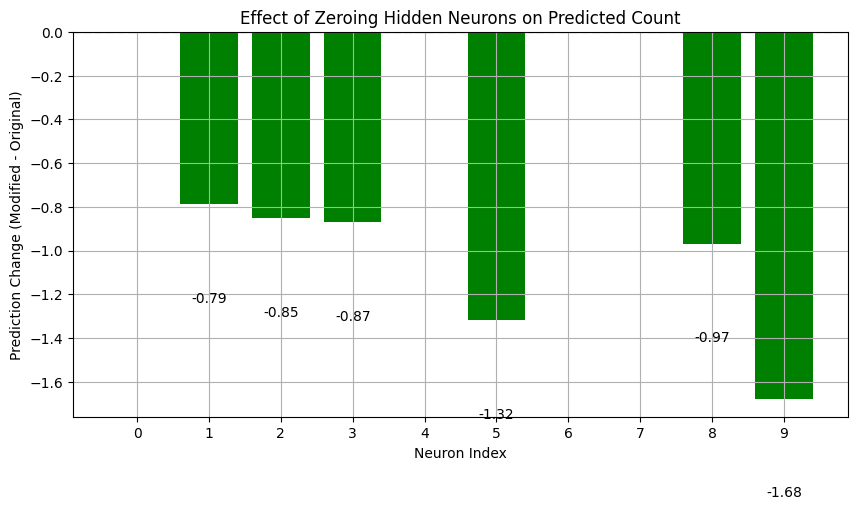

Neuron 1 → Prediction decreased by 0.79
Neuron 2 → Prediction decreased by 0.85
Neuron 3 → Prediction decreased by 0.87
Neuron 5 → Prediction decreased by 1.32
Neuron 8 → Prediction decreased by 0.97
Neuron 9 → Prediction decreased by 1.68



Sample: [0, 0, 1, 1, 1, 1, 1, 1]
🧾 True count: 6, Baseline prediction: 5.73


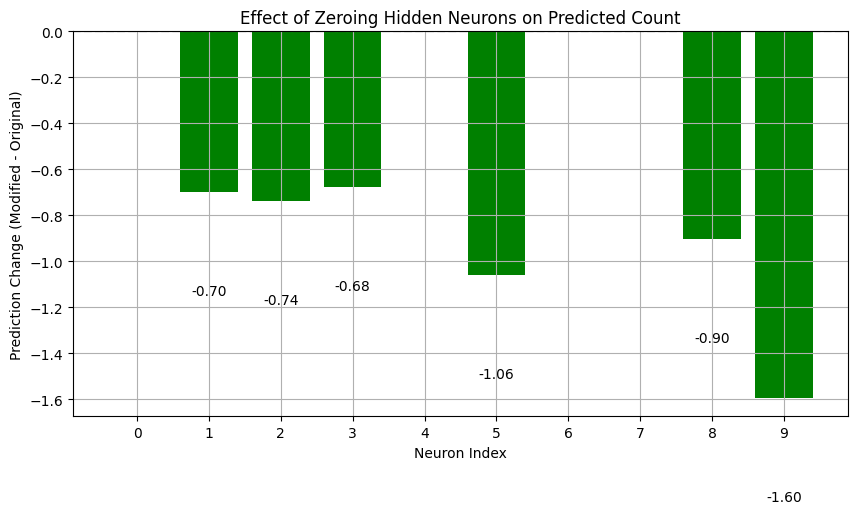

Neuron 1 → Prediction decreased by 0.70
Neuron 2 → Prediction decreased by 0.74
Neuron 3 → Prediction decreased by 0.68
Neuron 5 → Prediction decreased by 1.06
Neuron 8 → Prediction decreased by 0.90
Neuron 9 → Prediction decreased by 1.60



Sample: [0, 0, 0, 1, 1, 1, 1, 1]
🧾 True count: 5, Baseline prediction: 4.74


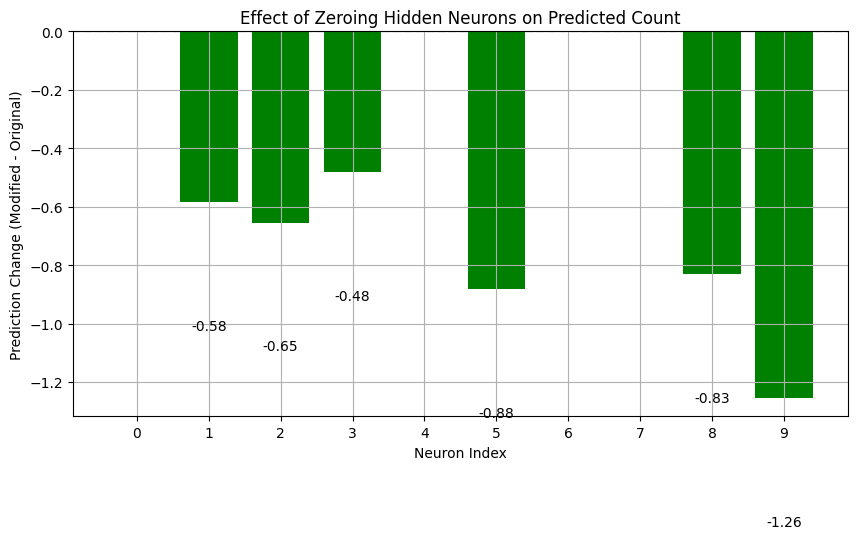

Neuron 1 → Prediction decreased by 0.58
Neuron 2 → Prediction decreased by 0.65
Neuron 3 → Prediction decreased by 0.48
Neuron 5 → Prediction decreased by 0.88
Neuron 8 → Prediction decreased by 0.83
Neuron 9 → Prediction decreased by 1.26



Sample: [0, 0, 0, 0, 1, 1, 1, 1]
🧾 True count: 4, Baseline prediction: 3.83


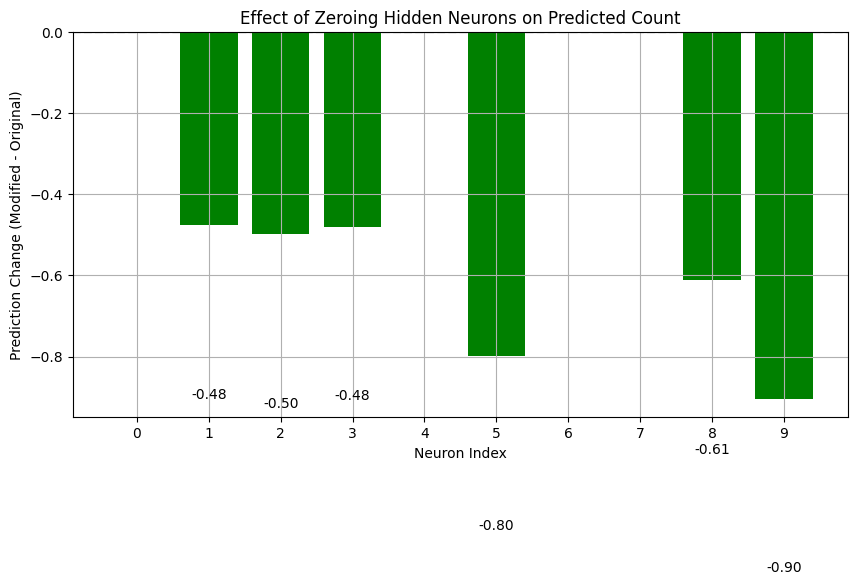

Neuron 1 → Prediction decreased by 0.48
Neuron 2 → Prediction decreased by 0.50
Neuron 3 → Prediction decreased by 0.48
Neuron 5 → Prediction decreased by 0.80
Neuron 8 → Prediction decreased by 0.61
Neuron 9 → Prediction decreased by 0.90



Sample: [0, 0, 0, 0, 0, 1, 1, 1]
🧾 True count: 3, Baseline prediction: 3.02


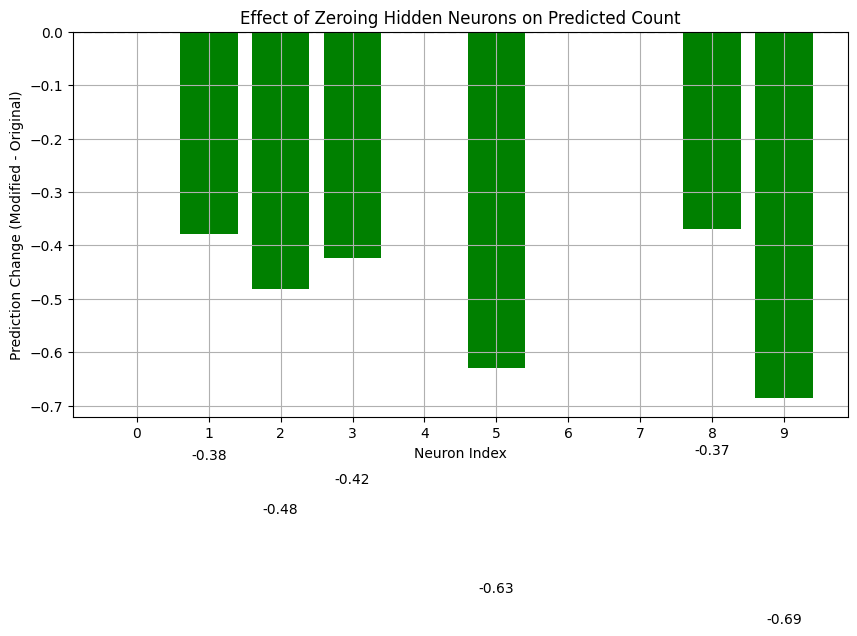

Neuron 1 → Prediction decreased by 0.38
Neuron 2 → Prediction decreased by 0.48
Neuron 3 → Prediction decreased by 0.42
Neuron 5 → Prediction decreased by 0.63
Neuron 8 → Prediction decreased by 0.37
Neuron 9 → Prediction decreased by 0.69



Sample: [0, 0, 0, 0, 0, 0, 1, 1]
🧾 True count: 2, Baseline prediction: 2.21


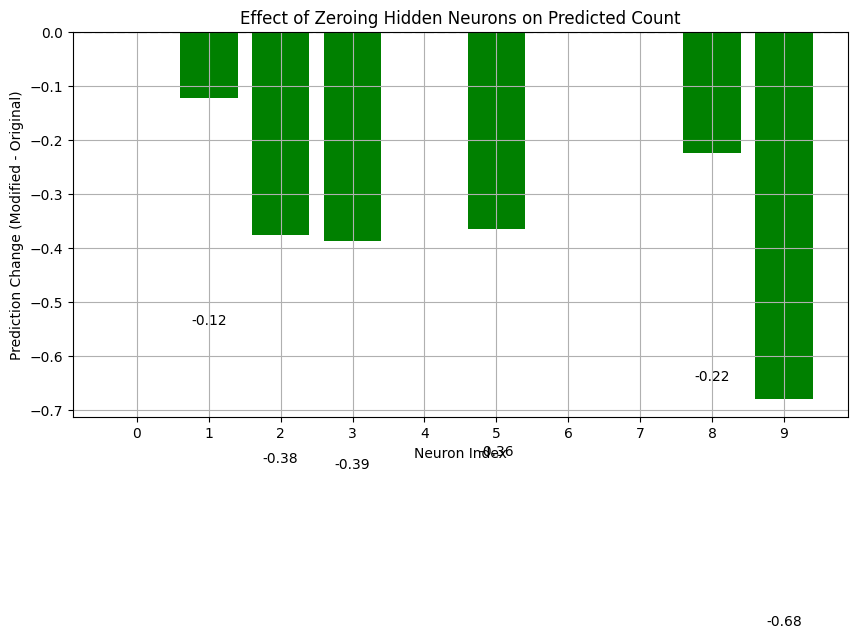

Neuron 1 → Prediction decreased by 0.12
Neuron 2 → Prediction decreased by 0.38
Neuron 3 → Prediction decreased by 0.39
Neuron 5 → Prediction decreased by 0.36
Neuron 8 → Prediction decreased by 0.22
Neuron 9 → Prediction decreased by 0.68



Sample: [0, 0, 0, 0, 0, 0, 0, 1]
🧾 True count: 1, Baseline prediction: 1.48


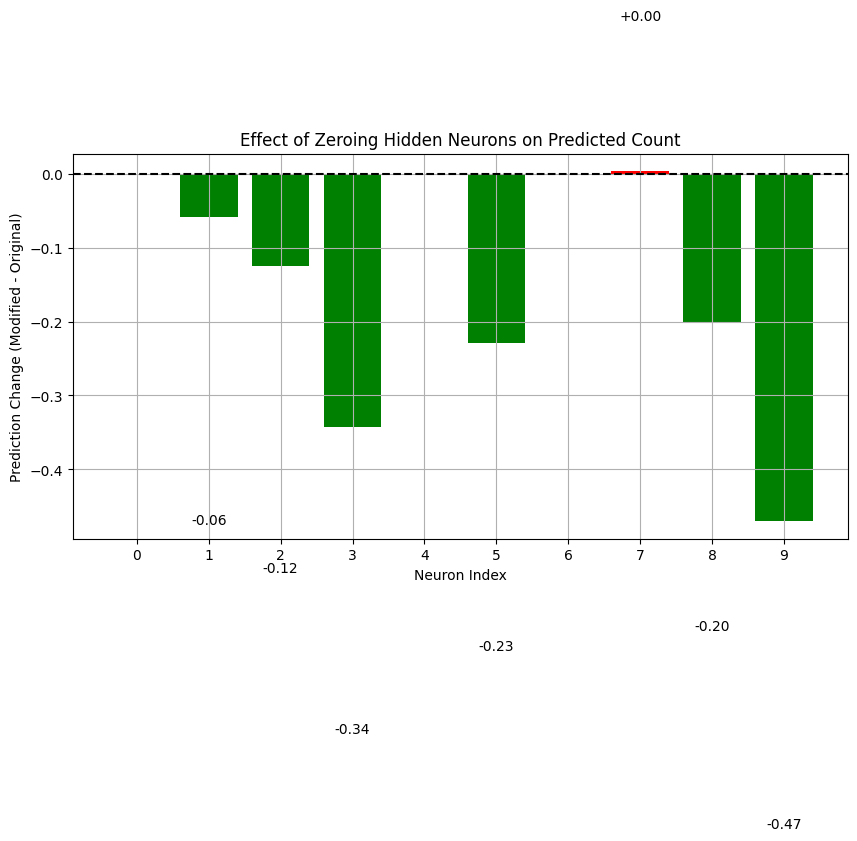

Neuron 1 → Prediction decreased by 0.06
Neuron 2 → Prediction decreased by 0.12
Neuron 3 → Prediction decreased by 0.34
Neuron 5 → Prediction decreased by 0.23
Neuron 7 → Prediction increased by 0.00
Neuron 8 → Prediction decreased by 0.20
Neuron 9 → Prediction decreased by 0.47



Sample: [0, 0, 0, 0, 0, 0, 0, 0]
🧾 True count: 0, Baseline prediction: 0.77


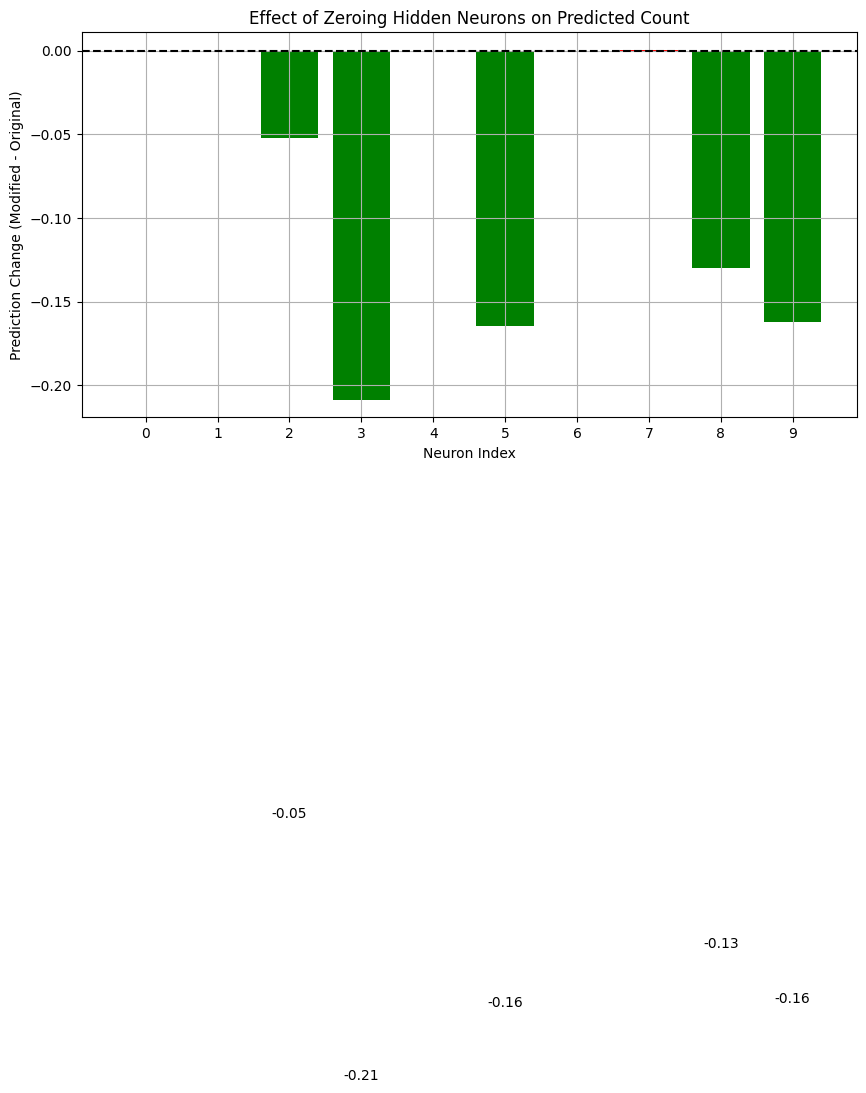

Neuron 2 → Prediction decreased by 0.05
Neuron 3 → Prediction decreased by 0.21
Neuron 5 → Prediction decreased by 0.16
Neuron 8 → Prediction decreased by 0.13
Neuron 9 → Prediction decreased by 0.16



Neuron 0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Neuron 1: [-0.7892026901245117, -0.6999597549438477, -0.5841031074523926, -0.4767179489135742, -0.3796982765197754, -0.12178254127502441, -0.059162139892578125, 0.0]
Neuron 2: [-0.8519387245178223, -0.7384405136108398, -0.6541323661804199, -0.4989628791809082, -0.4809408187866211, -0.3760329484939575, -0.12483859062194824, -0.051894426345825195]
Neuron 3: [-0.8685398101806641, -0.6763424873352051, -0.4818868637084961, -0.48075294494628906, -0.4242377281188965, -0.387068510055542, -0.3420814275741577, -0.20860880613327026]
Neuron 4: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Neuron 5: [-1.3178033828735352, -1.060750961303711, -0.8816843032836914, -0.7995367050170898, -0.628838062286377, -0.3643503189086914, -0.2292402982711792, -0.16473889

In [36]:
samples = [1, 1, 1, 1, 1, 1, 1, 1]
neurons = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
for i in range(8):
  samples[i] = 0
  print(f"Sample: {samples}")

  # Sample input to test
  test_input = torch.tensor([samples], dtype=torch.float32)
  true_count = int(test_input.sum().item())

  # Baseline prediction
  model.eval()
  with torch.no_grad():
      baseline_output, _ = model(test_input)
      baseline_pred = baseline_output.item()

  print(f"🧾 True count: {true_count}, Baseline prediction: {baseline_pred:.2f}")

  # Sweep: get signed change in scalar prediction
  neuron_indices = list(range(model.fc1.out_features))
  signed_deltas = []

  for i in neuron_indices:
      with torch.no_grad():
          h = F.relu(model.fc1(test_input))
          h[:, i] = 0  # zero out neuron i
          mod_output = model.fc2(h)
          mod_pred = mod_output.item()
          signed_deltas.append(mod_pred - baseline_pred)
          neurons[i].append(mod_pred - baseline_pred)

  # Plotting signed prediction change per neuron
  plt.figure(figsize=(10, 5))
  colors = ['green' if d < 0 else 'red' if d > 0 else 'gray' for d in signed_deltas]

  plt.bar(neuron_indices, signed_deltas, color=colors)
  plt.axhline(0, color='black', linestyle='--')
  plt.xticks(neuron_indices)
  plt.xlabel("Neuron Index")
  plt.ylabel("Prediction Change (Modified - Original)")
  plt.title("Effect of Zeroing Hidden Neurons on Predicted Count")
  plt.grid(True)

  # Annotatation
  for i, d in enumerate(signed_deltas):
      if abs(d) > 1e-3:
          plt.text(i, d + (0.2 if d > 0 else -0.4), f"{d:+.2f}",
                  ha='center', va='bottom' if d > 0 else 'top')

  plt.show()

  # Summary
  for i, d in enumerate(signed_deltas):
      if abs(d) > 1e-3:
          direction = "increased" if d > 0 else "decreased"
          print(f"Neuron {i} → Prediction {direction} by {abs(d):.2f}")
  print("\n\n")
for k,v in neurons.items():
  print(f"Neuron {k}: {v}")

Above, I did an another ablation neuron sweep for each test sample. The sample changes by adding a 0 to each position of the binary number. It seems that there is not much change and the prediction change is about the same for each of the neurons when zeroed.

However, it seems like when the binary is all 0s then the prediction change for each neuron is significantly lower, with the highest prediction decrease as 0.21.

I also printed out the prediction over time for each neuron. In this sweep, where there the binary turns from all 1s to all 0s, there is a decreasing pattern shown with the neuron's prediction changes. This is specifically for neurons 1, 2, 3, 5, 8, 9. Where neuron 9 has the highest impact for the number of 1s in the binary sample.

So I believe that neuron 9 learns the most from the number of 0s in the binary. As shown above, neuron 9 has the highest prediction decrease when zeroed out. When the number of 0s in the binary increases of decreases, neuron 9 has the biggest impact. Additionally when showing the decrease in number of 0s in the binary, neuron 9 has the biggest range of prediction change, starting from a decrease of 1.67 when the binary has all 1s to a decrease in only 0.16 when the binary has all 0s.

I learned how the model worked by testing different samples and how the predictions change if the samples incrementally change. Each neuron has an impact to the prediction, where some neurons can have a bigger impact of the prediction while other have absolutely no impact on the prediction.

It was confusing to single a specific feature of the model and understand what it does. This was because multiple neurons were in use together in impact of the predictions. So it was hard to interpret the results even zeroing out individual neurons.

I wish I could understand better how the neurons are specifically connected. It seems like some neurons have more similar impacts, maybe inferring that they are connected to make similar decisions.